In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.collections import LineCollection

In [ ]:
mob = pd.read_csv("data/yjmob100k-dataset1.csv.gz", compression="infer")

mob = mob.sort_values(["uid", "d", "t"]).reset_index(drop=True)

mob = mob.drop_duplicates(["uid","d","t","x","y"])

# Build Semantic Embeddings for Each Grid

In [3]:
poi = pd.read_csv("data/cell_POIcat.csv.gz", compression="infer")

poi_category= pd.read_csv("data/POI_datacategories.csv", header=None, names=["category"])

## Assign privacy budget to each poi category

In [ ]:
import pandas as pd
from google import genai
import time

client = genai.Client(api_key="xxx")

def get_sensitivity_score(category: str) -> float:
    prompt = f"""
You are a mobility privacy expert. Please evaluate how sensitive or privacy-related the following POI category is.
Return a single decimal number between 0 and 1 as the sensitivity score.

0 = Not sensitive at all (e.g., Park, Café, Bakery)
1 = Highly sensitive (e.g., Hospital, Religious site, Bank, Government office)

Important rules:
- Return only a number
- No explanation
- No additional text

POI Category: {category}
"""

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )
    
    text = response.text.strip()
    try:
        return float(text)
    except:
        return None

In [ ]:
# =======================
# LOOP over all categories
# =======================
results = {cat: [] for cat in poi_category["category"]}

num_rounds = 10

for cat in tqdm(poi_category["category"], desc="Scoring POIs"):
    for _ in range(num_rounds):
        score = get_sensitivity_score(cat)
        if score is not None:
            results[cat].append(score)
        time.sleep(0.3)

import numpy as np

records = []
for cat, score_list in results.items():
    if score_list:
        mean = np.mean(score_list)
        std = np.std(score_list)
    else:
        mean, std = None, None
    records.append([cat, mean, std])

df = pd.DataFrame(records, columns=["category", "mean_sensitivity", "std_sensitivity"])
df.to_csv("./data/poi_sensitivity_stats.csv", index=False)

print("✅ DONE. Saved to poi_sensitivity_stats.csv")

In [4]:
cat_stats = pd.read_csv("./data/poi_sensitivity_stats.csv")

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse

df = poi.copy()
df["grid_id"] = df["x"].astype(str) + "_" + df["y"].astype(str)
grid_ids = df["grid_id"].unique()
cat_ids = sorted(df["POIcategory"].unique())

grid_index = {g:i for i,g in enumerate(grid_ids)}
cat_index  = {c:i for i,c in enumerate(cat_ids)}

G = len(grid_ids)
C = len(cat_ids)


df["tw"] = np.log1p(df["POI_count"])
# df["tw"] = df["POI_count"] / df.groupby("grid_id")["POI_count"].transform("sum")


N = G
df_c = df.groupby("POIcategory")["grid_id"].nunique()        # df(c)
iwf = np.log((N + 1) / (df_c.reindex(cat_ids).fillna(0) + 1))  # 平滑

df["iwf"] = df["POIcategory"].map(iwf)


rows = df["grid_id"].map(grid_index).to_numpy()
cols = df["POIcategory"].map(cat_index).to_numpy()
vals = (df["tw"] * df["iwf"]).to_numpy()

W = sparse.csr_matrix((vals, (rows, cols)), shape=(G, C))

from sklearn.preprocessing import normalize
Wn = normalize(W, norm="l2", axis=1, copy=True)

grid_semantic_feature = pd.DataFrame(
    Wn.toarray(), index=grid_ids,
    columns=[f"cat_{c}" for c in cat_ids]
).rename_axis("grid_id").reset_index()

grid_semantic_feature[["x","y"]] = grid_semantic_feature["grid_id"].str.split("_", expand=True).astype(int)

In [ ]:
from sklearn.decomposition import PCA

num_cols = [c for c in grid_semantic_feature.columns if c.startswith("cat_")]
X = grid_semantic_feature[num_cols].values

pca = PCA(n_components=10, random_state=42)
grid_embedding = pca.fit_transform(X)  # shape: [num_grids, 10]

df_embedding = grid_semantic_feature[['grid_id','x','y']].copy()
for i in range(grid_embedding.shape[1]):
    df_embedding[f'emb_{i+1}'] = grid_embedding[:, i]

output_file = "grid_embedding.csv"
df_embedding.to_csv(output_file, index=False)
print(f"Saved embedding to {output_file}")

Saved embedding to grid_embedding.csv


In [ ]:
print("Converting to 3D tensor...")

# 1. Define target dimensions
MAX_X = 200
MAX_Y = 200
EMB_DIM = 10

# 2. Initialize an all-zero tensor
# Why initialize with zeros?
# Because some grid cells may contain no POIs at all and thus do not appear in df_embedding.
# These “empty” grid cells will remain zero vectors, which typically represent
# “no feature” or “padding” in deep learning models.
grid_tensor = np.zeros((MAX_X, MAX_Y, EMB_DIM), dtype=np.float32)

# 3. Safe filtering (to prevent index out of bounds)
# If x or y may exceed 199, this step drops out-of-range entries to avoid errors
mask_valid = (df_embedding['x'] < MAX_X) & (df_embedding['y'] < MAX_Y) & \
             (df_embedding['x'] >= 0) & (df_embedding['y'] >= 0)

df_valid = df_embedding[mask_valid].copy()
print(f"Valid grids: {len(df_valid)} / Total grids: {len(df_embedding)}")
if len(df_valid) < len(df_embedding):
    print("Warning: Some grid_id values are outside the 200x200 range and have been ignored.")

# 4. Extract coordinates and embedding vectors
# Note: ensure x corresponds to the first dimension and y to the second dimension
xs = df_valid['x'].values
ys = df_valid['y'].values

# Extract emb_1 to emb_10 columns
emb_cols = [f'emb_{i+1}' for i in range(EMB_DIM)]
vectors = df_valid[emb_cols].values  # shape: [N, 10]

# 5. Populate the tensor (core step)
# Use NumPy advanced indexing for direct assignment, avoiding Python loops for efficiency
grid_tensor[xs, ys] = vectors

# 6. Save to disk
output_npy = "city_grid_map.npy"
np.save(output_npy, grid_tensor)

print("-" * 30)
print(f"✅ Successfully generated: {output_npy}")
print(f"Shape: {grid_tensor.shape}")   # (200, 200, 10)
print(f"Dtype: {grid_tensor.dtype}")
print("-" * 30)

# Simple sanity check: print one grid cell with data
sample_idx = 0
sx, sy = xs[sample_idx], ys[sample_idx]
print(f"Verify grid cell ({sx}, {sy}) vector:")
print(grid_tensor[sx, sy])

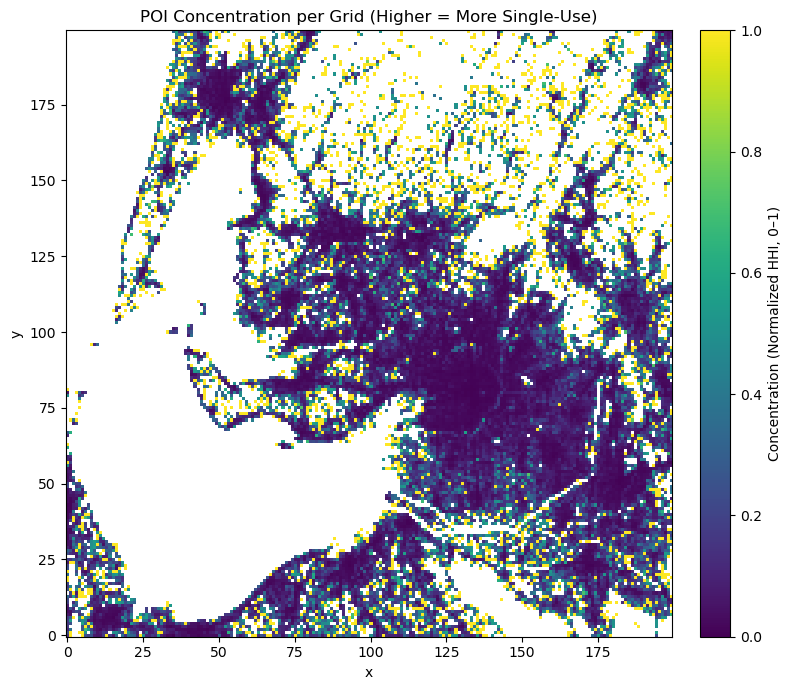

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

gdf = grid_semantic_feature.copy()

# -----------------------------
# 0) Basic settings
# -----------------------------
# Identify category columns and corresponding category IDs
cat_cols = [c for c in gdf.columns if c.startswith("cat_")]
cat_ids = np.array([int(c.split("_", 1)[1]) for c in cat_cols])
K = len(cat_cols)

# If the grid is expected to be 200×200, explicitly restrict the range
xmin, xmax = gdf["x"].min(), gdf["x"].max()
ymin, ymax = gdf["y"].min(), gdf["y"].max()
Width = xmax - xmin + 1
Height = ymax - ymin + 1

# Normalize TW-IWF values into probabilities p (row sum equals 1)
vals = gdf[cat_cols].to_numpy(dtype=float)
row_sum = vals.sum(axis=-1, keepdims=True)
p = np.divide(vals, row_sum, out=np.zeros_like(vals), where=(row_sum > 0))

hhi = (p**2).sum(axis=1)                 # (G,)
# Optionally compute a normalized concentration index:
# (HHI - 1/K) / (1 - 1/K) ∈ [0, 1]
hhi_norm = (hhi - 1.0 / K) / (1.0 - 1.0 / K)

gdf["hhi"] = hhi
gdf["hhi_norm"] = hhi_norm

# Construct grid-level concentration matrix
hhi_grid = np.full((Height, Width), fill_value=np.nan)
hhi_grid[gdf["y"].values - ymin, gdf["x"].values - xmin] = gdf["hhi_norm"].values

# Visualization
plt.figure(figsize=(8, 7))
im2 = plt.imshow(hhi_grid, origin="lower", cmap="viridis", vmin=0, vmax=1)
cbar2 = plt.colorbar(im2, fraction=0.046, pad=0.04)
cbar2.set_label("Concentration (Normalized HHI, 0–1)")
plt.title("POI Concentration per Grid (Higher = More Single-Use)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
# plt.savefig("grid_concentration.png", dpi=200)
plt.show()

## Calcualte each grid's privacy budget

In [ ]:
import numpy as np
from scipy import sparse

C = W.shape[1]
cat_ids_arr = np.asarray(cat_ids)

# —— Consistency check: lengths must match ——
assert len(cat_ids_arr) == C, f"cat_ids length {len(cat_ids_arr)} does not match W columns {C}"
assert len(cat_stats) == C,   f"cat_stats rows {len(cat_stats)} do not match W columns {C}"

# —— Directly take μ and σ by position, with numerical cleanup ——
mu  = np.clip(np.nan_to_num(cat_stats["mean_sensitivity"].to_numpy(float), nan=0.0), 0.0, 1.0)
std = np.clip(np.nan_to_num(cat_stats["std_sensitivity"].to_numpy(float),  nan=0.0), 0.0, 1.0)
var = std**2

# —— Row-normalize to obtain P (category distribution) ——
if sparse.issparse(W):
    row_sum = np.asarray(W.sum(axis=1)).ravel()
    row_sum_safe = np.where(row_sum > 0, row_sum, 1.0)
    P = sparse.diags(1.0 / row_sum_safe) @ W
else:
    row_sum = W.sum(axis=1)
    row_sum_safe = np.where(row_sum > 0, row_sum, 1.0)
    P = W / row_sum_safe[:, None]

# —— Expectation and variance propagation ——
S    = (P @ mu) if not sparse.issparse(P) else P.dot(mu)                 # (G,)
E_X2 = (P @ (var + mu**2)) if not sparse.issparse(P) else P.dot(var + mu**2)
Var  = np.maximum(E_X2 - S**2, 0.0)

# —— Optional: risk penalty / lower confidence bound / concentration weighting ——
lambda_penalty = 0.0
S_risk = S - lambda_penalty * np.sqrt(Var)
S_lb95 = S - 1.96 * np.sqrt(Var)

if "hhi_norm" in gdf.columns:
    alpha = 0.5
    conc_w = alpha + (1 - alpha) * gdf["hhi_norm"].to_numpy()
    S_conc = S * conc_w
else:
    S_conc = S

# Sanity check: S should not be all zeros
print("S range:", float(S.min()), float(S.max()))

# 5) Output aggregation
gdf = gdf.copy()
gdf["privacy_mean"] = S
gdf["privacy_var"]  = Var
gdf["privacy_lb95"] = S_lb95
gdf["privacy_conc"] = S_conc

privacy_df = gdf[
    ["grid_id", "privacy_mean", "privacy_var", "privacy_lb95", "privacy_conc"]
].copy()

out = gdf.merge(privacy_df, on="grid_id", how="left")

S range: 0.0 1.0


In [11]:
out.to_csv("grid_privacy_scores.csv", index=False)

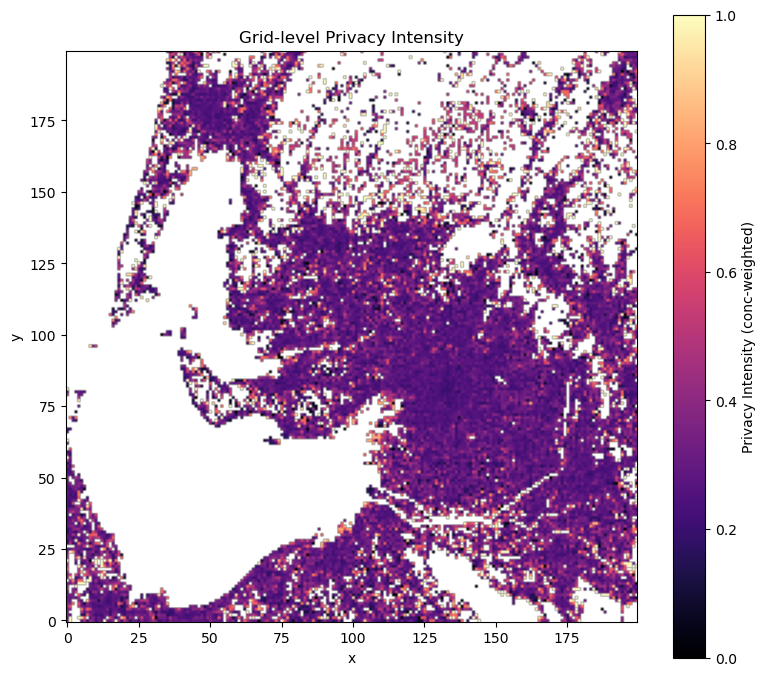

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
out = pd.read_csv("grid_privacy_scores.csv")
xmin, xmax = out["x"].min(), out["x"].max()
ymin, ymax = out["y"].min(), out["y"].max()
W = xmax - xmin + 1
H = ymax - ymin + 1
img = np.full((H, W), np.nan)
img[out["y"] - ymin, out["x"] - xmin] = out["privacy_conc"].values
plt.figure(figsize=(8, 7))
im = plt.imshow(img, origin="lower", cmap="magma", vmin=0, vmax=1)
plt.colorbar(im, label="Privacy Intensity (conc-weighted)")
plt.title("Grid-level Privacy Intensity")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()